# Integrating bimonthly approach
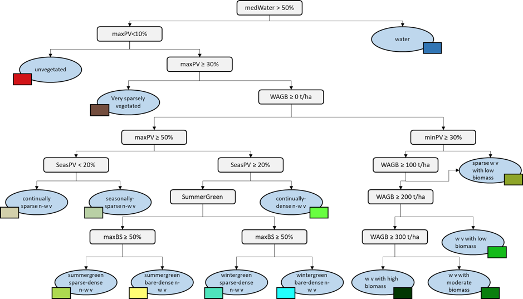


Current idea attempted below
1. use simple max bimonthly values to play endmembers off to each other (i.e. non veg == BS > PV and BS > NPV)
    - works relatively well, but due to high reflective surfaces (that may be outliers for BSmax) cultivated areas can be identified as bare areas
2. see if aggregating data to bimonthly instead of monthly in FCcc function is more robust
    - did not find a useful/meaningful way to do this 
3. can we use simple rules based on max/min of bimonthly yearly summaries (i.e. non veg == BSmax > PVmax & NPVmax and NPVmin < BSmin)?
    - already integrated as a combined bimonthly, outputs seem very similar (i.e. max biomonthly for identifying veg and min biomonthly for identifying veg)
4. similar to idea 1, but make BS endmember be dominant, not just a higher value for max/min than PV/NPV
    - implementation idea is that for non veg to prevail BS must be greater than PV/NPV and PV/NPV must be < 50 (i.e. not the dominant endmember for the given observation)
    - gives slightly better results that idea 1, comparable to current FCcc approach


In [1]:
import os, sys, copy
import yaml
import numpy as np
import xarray as xr
import pickle

from itertools import groupby
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import datacube
from datacube.storage import masking
from datacube.virtual import catalog_from_file
from datacube.utils.geometry import CRS
from datacube.helpers import write_geotiff

dc = datacube.Datacube()

/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


In [2]:
# AWS or Gadi
service = '/home/jovyan/development/'
# service = '/g/data/u46/users/bt2744/work/code/'

sys.path.append(str(service)+"dea-notebooks/Scripts")
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten

sys.path.append(os.path.abspath(str(service)+"livingearth_australia/le_plugins"))

In [3]:
# loading extents from yaml Dan prepared, just change site_name to tile interested in from our 16 test sites
yaml_sites_file = os.path.abspath(str(service)+"chris_leaust_testing/notebooks/misc/au_test_sites.yaml")

with open(yaml_sites_file, "r") as f:
    site_config = yaml.safe_load(f)

site_name = "SW Tassie"
extent_x = [site_config[site_name]["min_x"],
            site_config[site_name]["max_x"]]
extent_y = [site_config[site_name]["min_y"],
            site_config[site_name]["max_y"]]

crs = "EPSG:3577"
res = (-100, 100)
time = ("2015-01-01", "2015-12-31")
query =({'time': time,
             'x':extent_x,
            'y':extent_y,
            'crs':crs,
            'resolution':res})

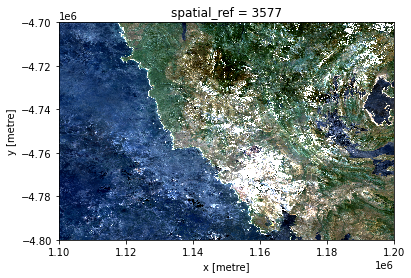

In [4]:
# Load Landsat
geomedian = dc.load(product="ls8_nbart_geomedian_annual", **query)
geomedian = masking.mask_invalid_data(geomedian).squeeze().drop('time')
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)

In [5]:
# datacube functions to load in a virtual product from recipe
catalog = catalog_from_file(service+'chris_leaust_testing/notebooks/misc/virtual_product_cat.yaml')

In [6]:
# load fc wofs mask (already masked out by water flag from wofs as nan values in vp)
product = catalog['ls_fc_wofs_masked']
ls_fc_wofs_masked = product.load(dc, **query)

# add water (no masking applied here, just raw wofs, so no nans at present)
product = catalog['wofs_daily']
wofs = product.load(dc, **query)
ls_fc_wofs_masked['water'] = wofs.water

#### first, create established FCcc + si5 product for comparison

In [7]:
data = ls_fc_wofs_masked

def consecutive_count_veg(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of veg (1) for each pixel across the time series

    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 1's to be classified as veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is veg (1)     
    '''

    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = tv_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive veg classifications
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 1]

            if not counts:
                consecutive_numpy[y,x] = 0
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 1
            else:
                consecutive_numpy[y,x] = 0

    return consecutive_numpy

def consecutive_count_nonveg(tv_numpy, consecutive_numpy, required_consecutive, consec_msk_val=1):
    '''
    function to get consective count of non veg (0) for each pixel across the time series

    :param numpy.array tv_numpy: 3-D array of tv[z,y,x]
    :param numpy.array consecutive_numpy: bool output array for veg (1) and non veg (0)
    :param float required_consecutive: how many consectutive 0's to be classified as non veg?
    :param float consec_msk_val: what value to calculcate consectutives on
           default is non veg (0)     
    '''

    for y in range(tv_numpy.shape[1]):
        for x in range(tv_numpy.shape[2]):
            # If all the values are nan then just set output to nan and carry on
            pixel = tv_numpy[:,y,x]

            if np.all(np.isnan(pixel)):
                consecutive_numpy[y,x] = np.nan
                continue            

            # Get counts of consecutive non veg classifications (hence label == 0)
            counts = [len(list(group)) for label, group in groupby(pixel[(~np.isnan(pixel))]) if label == 0]

            # Inversed values from consecutive_count_veg to make non veg
            if not counts:
                consecutive_numpy[y,x] = 1
            elif max(counts) >= required_consecutive:
                consecutive_numpy[y,x] = 0
            else:
                consecutive_numpy[y,x] = 1

    return consecutive_numpy

data_nan = masking.mask_invalid_data(data)

# Create water and low-quality fc masks
no_water = np.invert( (data['water'] == 128) | (data['water'] == 132) )
high_ue = (data['UE'] > 30) & no_water

# Set to null areas with high UE, but no water
data_nan = data_nan.where(np.invert(high_ue))

# Don't need this anymore
data_nan = data_nan.drop("UE")
del high_ue

# Where there's water, set PV to 0
data_nan['PV'] = data_nan.PV.where(no_water, 0)
data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

# Where there's water, set BS to 100
data_nan['BS'] = data_nan.BS.where(no_water, 100)

# Don't need this anymore
data_nan = data_nan.drop("water")
del no_water

data_month = data_nan.groupby('time.month').median(dim='time')    

# Create mask where PV > BS
PV_dominant = data_month['PV'] > data_month['BS']
PV_dominant_nan = PV_dominant.where((data_month['PV'] >= 0) & (data_month['BS'] >= 0))

# Create mask where NPV > BS
NPV_dominant = data_month['NPV'] > data_month['BS']
NPV_dominant_nan = NPV_dominant.where((data_month['NPV'] >= 0) & (data_month['BS'] >= 0))

# Veg where PV or NPV are greater than BS
tv_mask = (PV_dominant_nan + NPV_dominant_nan)

# Make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

##### veg #####
# Executing consecutive_count function #
# veg and non veg = 2 consecutive months
required_consecutive = 2

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# For veg - run function to get array of with 1 where number of consecutive values for 
# different dates is >= required_consecutive
consecutive_numpy_veg = consecutive_count_veg(tv_numpy, consecutive_numpy, required_consecutive)

# Reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
tv_reduce = tv_mask.max(dim='month')

# Create new data array with sampe dimensions as original
tv_summary_veg = xr.DataArray(consecutive_numpy_veg, coords=tv_reduce.coords, dims=tv_reduce.dims)  

##### non veg #####
# Executing consecutive_count function #
# veg and non veg = 2 consecutive months
required_consecutive = 2        

# Pull tv as numpy array
tv_numpy = tv_mask_xr.values        

# Set up array for output (faster to pre-allocate for numba).
# Needs to be float32 for NaN
consecutive_numpy = np.empty((tv_numpy.shape[1], tv_numpy.shape[2]), dtype=np.float32)

# For non veg - run function to get array of with 0 where number of consecutive values for 
# different dates is >= required_consecutive
consecutive_numpy_nonveg = consecutive_count_nonveg(tv_numpy, consecutive_numpy, required_consecutive)

# Reduce original array to 2D
# using max here but not important as we just want to use shape/attributes
tv_reduce = tv_mask.max(dim='month')

# Create new data array with sampe dimensions as original
tv_summary_nonveg = xr.DataArray(consecutive_numpy_nonveg, coords=tv_reduce.coords, dims=tv_reduce.dims)

## Combine veg and non veg masks (to ensure no data is correctly identified)
tv_combine = tv_summary_veg + tv_summary_nonveg

# Make values of 2 == 1 (end result in binary veg mask)
tv_combine_drop = np.where(tv_combine == 2, 1, tv_combine)

# Create new data array with sampe dimensions as original
tv_summary = xr.DataArray(tv_combine_drop, coords=tv_reduce.coords, dims=tv_reduce.dims)

# making wofs mask product
wofs_ann = dc.load(product="wofs_annual_summary", measurements=["frequency"], **query)
wofs_mask = 1-((wofs_ann["frequency"] >= 0.2)).squeeze().drop('time')

# making si5 product
# load best pixel geomedian
product = catalog['best_pixel_gm']
best_pixel_gm = product.load(dc, **query)

best_pixel_gm['si5'] = ((best_pixel_gm['blue']*best_pixel_gm['red'])/best_pixel_gm['green']).drop('time').squeeze()
si5 = best_pixel_gm.si5
si5.values = np.where(si5 < 1500, 1, 0)

# current best level 1 product
vegetat_veg_cat_current = tv_summary * wofs_mask * si5

#### idea 1: use simple max bimonthly values to play endmembers off to each other

##### first, correct all the data (FC and water)

In [8]:
## basically first step is to get good data for FC observations ##
# change of name so works with consecutive count function
data = ls_fc_wofs_masked
# mask_invalid_data used here as some of the FC fractions may contain -ve values so this makes sure everything goes from 0-100%
# doesn't change anything for water dataset (as no nans in product at present)
data_nan = masking.mask_invalid_data(data)

In [9]:
# Create water and low-quality fc masks
# create dataset no water present: water (0) and no water (1) (128 clear and wet; 132 clear and wet and sea)
# invert used here otherwise would be water (1) and no water (0)
no_water = np.invert((data['water'] == 128) | (data['water'] == 132))

# where uncertainty error of pixel is high (i.e. > 30) and no water is present (1)
# this is to remove bad terrestrial data that we not picked up by the water mask of the vp
high_ue_no_water = (data['UE'] > 30) & no_water

# Set to null areas with high UE, but no water
data_nan = data_nan.where(np.invert(high_ue_no_water))

In [10]:
# Don't need UE anymore, done its job
data_nan = data_nan.drop("UE")

# Where there's water, set PV to 0
data_nan['PV'] = data_nan.PV.where(no_water, 0)
data_nan['NPV'] = data_nan.NPV.where(no_water, 0)

# Where there's water, set BS to 100
data_nan['BS'] = data_nan.BS.where(no_water, 0)

# Where there's water, set water to 1
# invert no water (1) to water (could have mad a water mask before to stop inverting things, but this does the job for now)
water = np.invert(no_water)
# Where there's no water on our data_nan product set water to 0
data_nan['water'] = data_nan.water.where(water, 0)
# Where there's values for water that are 0, keep, otherwise all other values make 1
data_nan['water'] = data_nan.water.where(data_nan['water'] == 0, 1)

# now mask out nan values of water using FC
PV = data_nan.PV.isnull()
data_nan = data_nan.where(np.invert(PV))

##### second, get bimonthly medians and calculate summary metrics

In [11]:
# Resample to combine each 2 months of data into a median composite
data_bimonthly = data_nan.resample(time='2m', closed='left').median()

In [12]:
# Calculate summary bimonthly metrics
medWater = data_bimonthly.water.median(dim='time')
minPV = data_bimonthly.PV.min(dim='time')
maxPV = data_bimonthly.PV.max(dim='time')
minNPV = data_bimonthly.NPV.min(dim='time')
maxNPV = data_bimonthly.NPV.max(dim='time')
minBS = data_bimonthly.BS.min(dim='time')
maxBS = data_bimonthly.BS.max(dim='time')

##### third, use similar logic to FCcc function calculated bimonthly max and min and view difference

In [13]:
### bimonthly max
# Create mask where PV > BS
PV_dominant = maxPV > maxBS
PV_dominant_nan = PV_dominant.where((maxPV >= 0) & (maxBS >= 0))

# Create mask where NPV > BS
NPV_dominant = maxNPV > maxBS
NPV_dominant_nan = NPV_dominant.where((maxNPV >= 0) & (maxBS >= 0))

# Veg where PV or NPV are greater than BS
tv_mask = (PV_dominant_nan + NPV_dominant_nan)

# Make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_maxbimonthly_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

### bimonthly min
# Create mask where PV > BS
PV_dominant = minPV > minBS
PV_dominant_nan = PV_dominant.where((minPV >= 0) & (minBS >= 0))

# Create mask where NPV > BS
NPV_dominant = minNPV > minBS
NPV_dominant_nan = NPV_dominant.where((minNPV >= 0) & (minBS >= 0))

# Veg where PV or NPV are greater than BS
tv_mask = (PV_dominant_nan + NPV_dominant_nan)

# Make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_minbimonthly_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

##### fourth, create two combinations (and | or)
- looking at results, the OR combination is better and closely alligns to FCcc outputs. The and combination is too restrictive to veg, particularly in agricultural areas

In [14]:
# combining max and min (i.e. veg == where tv_maxbimonthly_mask_xr and tv_minbimonthly_mask_xr say veg)
tv_mask_combined = (tv_maxbimonthly_mask_xr + tv_minbimonthly_mask_xr)

# Make values of 2 == 1 (end result in binary veg mask)
# tv_mask_drop_combined_and == both max and min veg must be satisfied (i.e. stricter veg mask)
tv_mask_drop_combined_and = np.where(tv_mask_combined == 2, 1, 0)
tv_bimonthly_combined_and = xr.DataArray(tv_mask_drop_combined_and, coords=tv_mask_combined.coords, dims=tv_mask_combined.dims)

# tv_mask_drop_combined_or == max or min veg must be satisfied (i.e. more lenient veg mask)
tv_mask_drop_combined_or = np.where(tv_mask_combined == 2, 1, tv_mask_combined)
tv_bimonthly_combined_or = xr.DataArray(tv_mask_drop_combined_or, coords=tv_mask_combined.coords, dims=tv_mask_combined.dims)

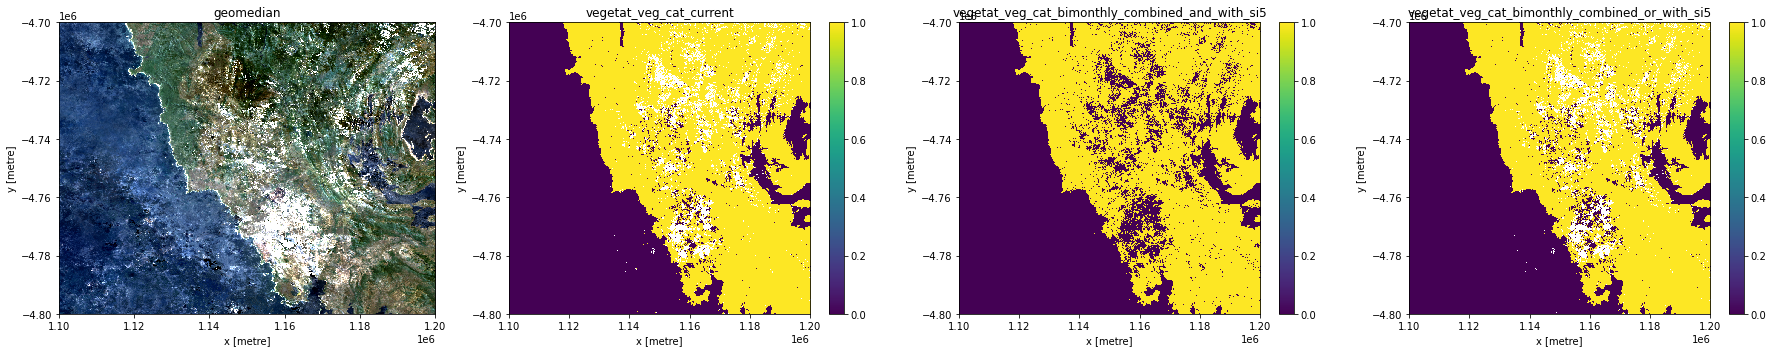

In [15]:
vegetat_veg_cat_bimonthly_combined_and_with_si5 = tv_bimonthly_combined_and * wofs_mask * si5
vegetat_veg_cat_bimonthly_combined_or_with_si5 = tv_bimonthly_combined_or * wofs_mask * si5

plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
vegetat_veg_cat_current.plot.imshow()
ax2.set_title('vegetat_veg_cat_current')

ax3=plt.subplot(gs[0,2])
vegetat_veg_cat_bimonthly_combined_and_with_si5.plot.imshow()
ax3.set_title('vegetat_veg_cat_bimonthly_combined_and_with_si5')

ax4=plt.subplot(gs[0,3])
vegetat_veg_cat_bimonthly_combined_or_with_si5.plot.imshow()
ax4.set_title('vegetat_veg_cat_bimonthly_combined_or_with_si5')

plt.tight_layout()
plt.show()

#### idea 2: see if aggregating data to bimonthly instead of monthly in FCcc function is more robust
- overall the bimonthly data reflects a more robust veg/non veg than monthly, although how would this be used in consecutive count function?
    - if using consecutive count == 1 (i.e. 1 bimonthly == 2 months for FAO definition) then we would get overclassification of veg
    - if using consecutive count == 3, or just count >= 3 (i.e. is it veg for the majority of the year?) then we would get underclassification of veg
    - i'm not seeing a sensible solution for using consecutive count function if we go with bimonthly's

In [16]:
# just want to see what veg/nonveg for bimonthly medians looks like for a year
# Create mask where PV > BS
PV_dominant = data_bimonthly['PV'] > data_bimonthly['BS']
PV_dominant_nan = PV_dominant.where((data_bimonthly['PV'] >= 0) & (data_bimonthly['BS'] >= 0))

# Create mask where NPV > BS
NPV_dominant = data_bimonthly['NPV'] > data_bimonthly['BS']
NPV_dominant_nan = NPV_dominant.where((data_bimonthly['NPV'] >= 0) & (data_bimonthly['BS'] >= 0))

# Veg where PV or NPV are greater than BS
tv_mask = (PV_dominant_nan + NPV_dominant_nan)

# Make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_bimonthly_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

#### idea 3: use simple rules based on max/min of bimonthly yearly summaries (i.e. non veg == BSmax > PVmin & NPVmin?)
- results suggest this method doesn't scale well, not worth pursing i think

In [17]:
# just plotting up veg as max biomonthly's and min bimonthly's to see differences and if these can be used in combination
### bimonthly minPV/NPV
# Create mask where PV > BS
PV_dominant = minPV > maxBS
PV_dominant_nan = PV_dominant.where((minPV >= 0) & (maxBS >= 0))

# Create mask where NPV > BS
NPV_dominant = minNPV > maxBS
NPV_dominant_nan = NPV_dominant.where((minNPV >= 0) & (maxBS >= 0))

# Veg where PV or NPV are greater than BS
tv_mask = (PV_dominant_nan + NPV_dominant_nan)

# Make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_minbimonthly_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

In [18]:
### bimonthly maxPV/NPV
# Create mask where PV > BS
PV_dominant = maxPV > minBS
PV_dominant_nan = PV_dominant.where((maxPV >= 0) & (minBS >= 0))

# Create mask where NPV > BS
NPV_dominant = maxNPV > minBS
NPV_dominant_nan = NPV_dominant.where((maxNPV >= 0) & (minBS >= 0))

# Veg where PV or NPV are greater than BS
tv_mask = (PV_dominant_nan + NPV_dominant_nan)

# Make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_maxbimonthly_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

#### idea 4: similar to idea 1, but make BS endmember be dominant, not just a higher value for max/min than PV/NPV
- implemtation idea is that for non veg to prevail BS must be greater than PV/NPV and PV/NPV must be < 50 (i.e. not the dominant endmember for the given observation)

In [19]:
### bimonthly max
# Create mask where PV > BS
PV_dominant = maxPV > maxBS
PV_dominant_nan = PV_dominant.where((maxPV >= 0) & (maxBS >= 0))
# also have clause that PVmax must be > 50 meaning that the equivilant BS value for PVmax had to have been the dominant endmember
# I think in effect this will mean non veg had to have been very evident for the year
PV_dominant_PV50 = maxPV > 50
PV_dominant_PV50_nan = PV_dominant_PV50.where((maxPV >= 0) & (maxBS >= 0))

PV_dominant_total = (PV_dominant_nan + PV_dominant_PV50_nan)
PV_dominant_total_mask_drop = np.where(PV_dominant_total == 2, 1, PV_dominant_total)
PV_dominant_total_mask_xr = xr.DataArray(PV_dominant_total_mask_drop, coords=PV_dominant_total.coords, dims=PV_dominant_total.dims)

# Create mask where NPV > BS
NPV_dominant = maxNPV > maxBS
NPV_dominant_nan = NPV_dominant.where((maxNPV >= 0) & (maxBS >= 0))

NPV_dominant_NPV50 = maxNPV > 50
NPV_dominant_NPV50_nan = NPV_dominant_NPV50.where((maxNPV >= 0) & (maxBS >= 0))

NPV_dominant_total = (NPV_dominant_nan + NPV_dominant_NPV50_nan)
NPV_dominant_total_mask_drop = np.where(NPV_dominant_total == 2, 1, NPV_dominant_total)
NPV_dominant_total_mask_xr = xr.DataArray(NPV_dominant_total_mask_drop, coords=NPV_dominant_total.coords, dims=NPV_dominant_total.dims)

# Veg where PV or NPV are greater than BS
tv_mask = (PV_dominant_total_mask_xr + NPV_dominant_total_mask_xr)

# Make values of 2 == 1 (end result in binary veg mask)
tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
tv_maxbimonthly_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

# ### bimonthly min
# # Create mask where PV > BS
# PV_dominant = minPV > minBS
# PV_dominant_PV50 = minPV > 50
# PV_dominant_total = PV_dominant + PV_dominant_PV50
# PV_dominant_nan = PV_dominant_total.where((minPV >= 0) & (minBS >= 0))

# # Create mask where NPV > BS
# NPV_dominant = minNPV > minBS
# NPV_dominant_NPV50 = minNPV > 50
# NPV_dominant_total = NPV_dominant + NPV_dominant_NPV50
# NPV_dominant_nan = NPV_dominant_total.where((minNPV >= 0) & (minBS >= 0))

# # Veg where PV or NPV are greater than BS
# tv_mask = (PV_dominant_nan + NPV_dominant_nan)

# # Make values of 2 == 1 (end result in binary veg mask)
# tv_mask_drop = np.where(tv_mask == 2, 1, tv_mask)
# tv_minbimonthly_mask_xr = xr.DataArray(tv_mask_drop, coords=tv_mask.coords, dims=tv_mask.dims)

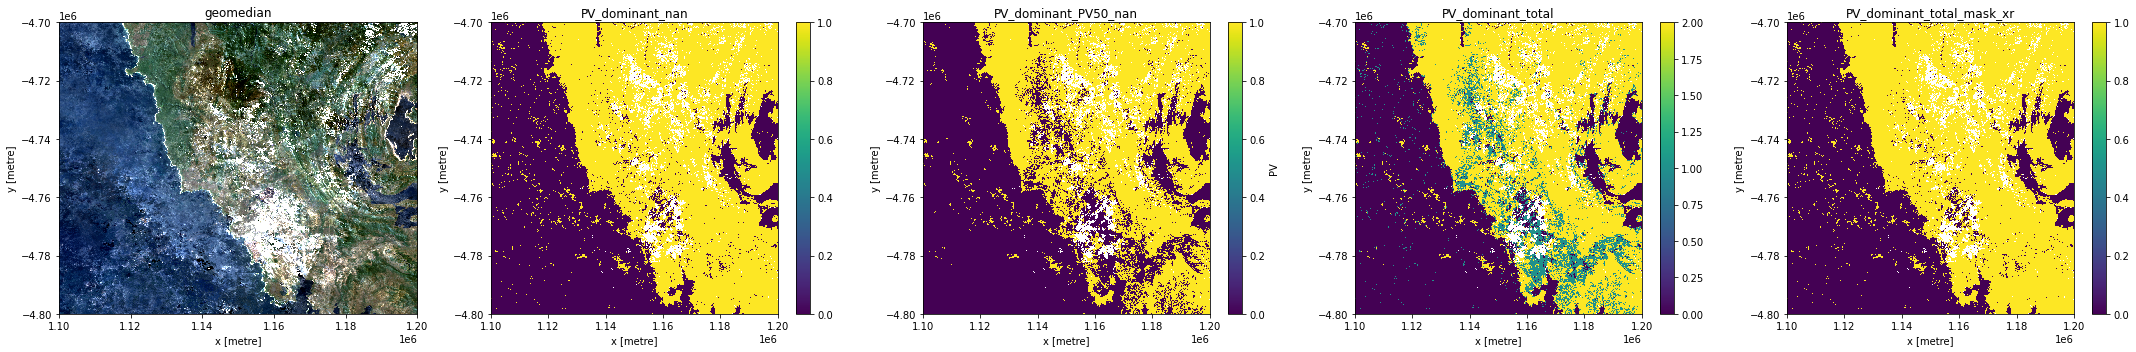

In [20]:
plt.figure(figsize=(30,5))
gs = gridspec.GridSpec(1,5)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
PV_dominant_nan.plot.imshow()
ax2.set_title('PV_dominant_nan')

ax3=plt.subplot(gs[0,2])
PV_dominant_PV50_nan.plot.imshow()
ax3.set_title('PV_dominant_PV50_nan')

ax4=plt.subplot(gs[0,3])
PV_dominant_total.plot.imshow()
ax4.set_title('PV_dominant_total')

ax5=plt.subplot(gs[0,4])
PV_dominant_total_mask_xr.plot.imshow()
ax5.set_title('PV_dominant_total_mask_xr')

plt.tight_layout()
plt.show()

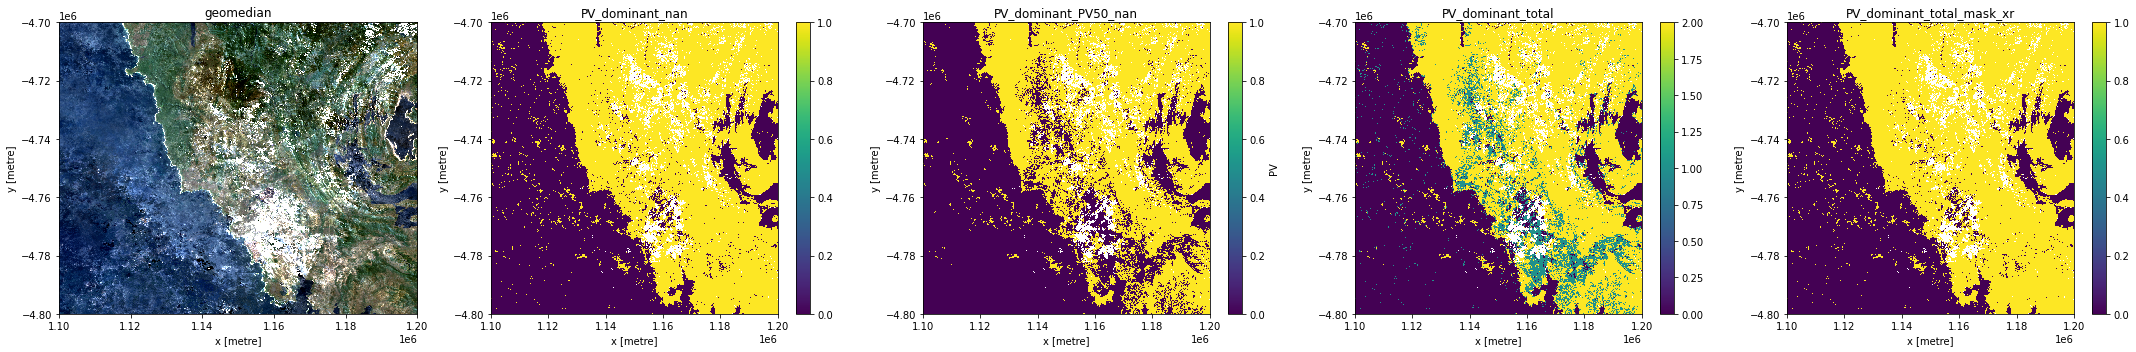

In [21]:
plt.figure(figsize=(30,5))
gs = gridspec.GridSpec(1,5)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
PV_dominant_nan.plot.imshow()
ax2.set_title('PV_dominant_nan')

ax3=plt.subplot(gs[0,2])
PV_dominant_PV50_nan.plot.imshow()
ax3.set_title('PV_dominant_PV50_nan')

ax4=plt.subplot(gs[0,3])
PV_dominant_total.plot.imshow()
ax4.set_title('PV_dominant_total')

ax5=plt.subplot(gs[0,4])
PV_dominant_total_mask_xr.plot.imshow()
ax5.set_title('PV_dominant_total_mask_xr')

plt.tight_layout()
plt.show()

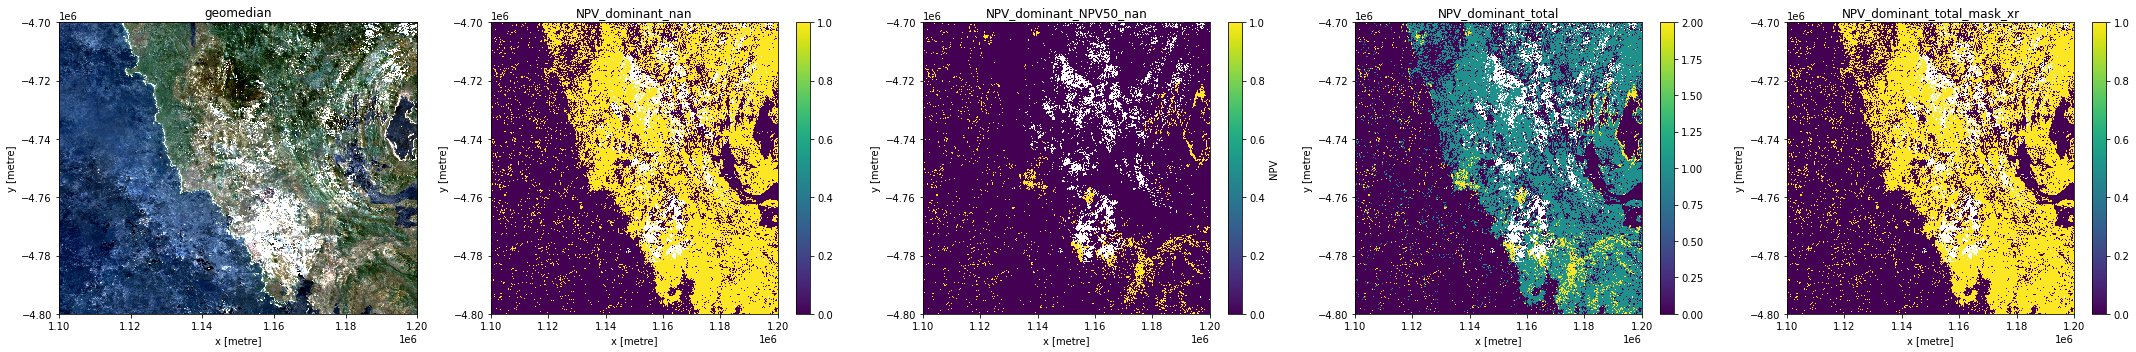

In [22]:
plt.figure(figsize=(30,5))
gs = gridspec.GridSpec(1,5)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
NPV_dominant_nan.plot.imshow()
ax2.set_title('NPV_dominant_nan')

ax3=plt.subplot(gs[0,2])
NPV_dominant_NPV50_nan.plot.imshow()
ax3.set_title('NPV_dominant_NPV50_nan')

ax4=plt.subplot(gs[0,3])
NPV_dominant_total.plot.imshow()
ax4.set_title('NPV_dominant_total')

ax5=plt.subplot(gs[0,4])
NPV_dominant_total_mask_xr.plot.imshow()
ax5.set_title('NPV_dominant_total_mask_xr')

plt.tight_layout()
plt.show()

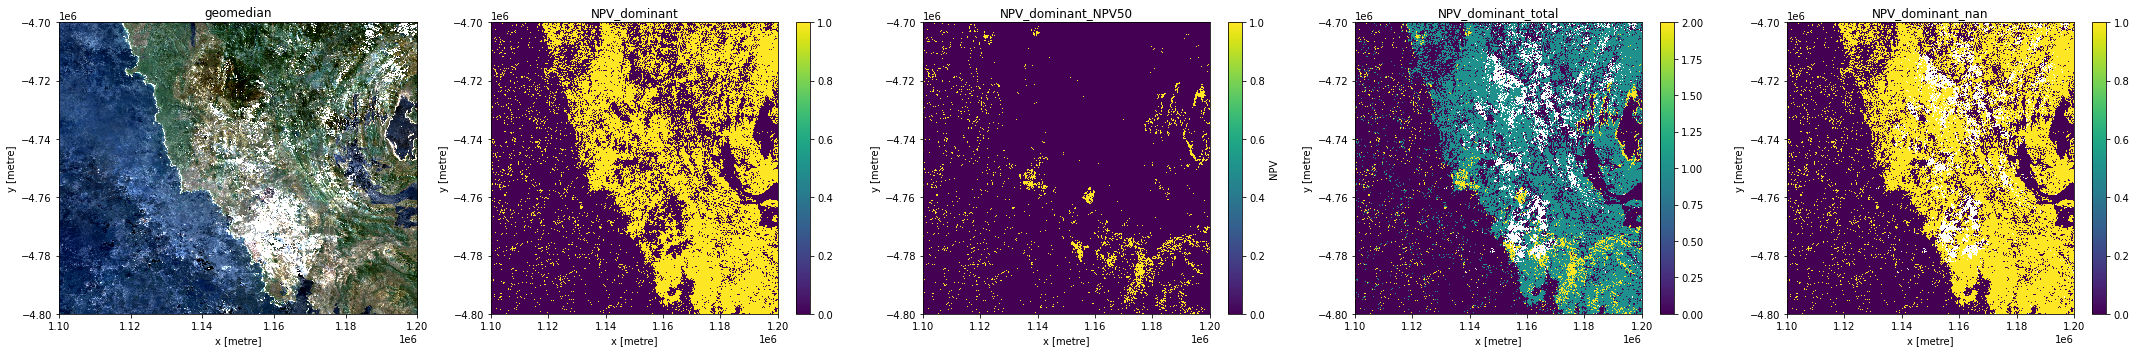

In [23]:
plt.figure(figsize=(30,5))
gs = gridspec.GridSpec(1,5)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
NPV_dominant.plot.imshow()
ax2.set_title('NPV_dominant')

ax3=plt.subplot(gs[0,2])
NPV_dominant_NPV50.plot.imshow()
ax3.set_title('NPV_dominant_NPV50')

ax4=plt.subplot(gs[0,3])
NPV_dominant_total.plot.imshow()
ax4.set_title('NPV_dominant_total')

ax5=plt.subplot(gs[0,4])
NPV_dominant_nan.plot.imshow()
ax5.set_title('NPV_dominant_nan')

plt.tight_layout()
plt.show()

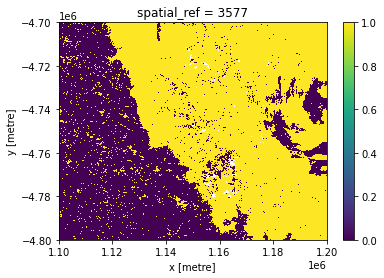

In [24]:
tv_maxbimonthly_mask_xr.plot()

In [25]:
# combining max and min (i.e. veg == where tv_maxbimonthly_mask_xr and tv_minbimonthly_mask_xr say veg)
tv_mask_combined = (tv_maxbimonthly_mask_xr + tv_minbimonthly_mask_xr)

# tv_mask_drop_combined_or == max or min veg must be satisfied (i.e. more lenient veg mask)
tv_mask_drop_combined_or = np.where(tv_mask_combined == 2, 1, tv_mask_combined)
tv_bimonthly_combined_or_50 = xr.DataArray(tv_mask_drop_combined_or, coords=tv_mask_combined.coords, dims=tv_mask_combined.dims)

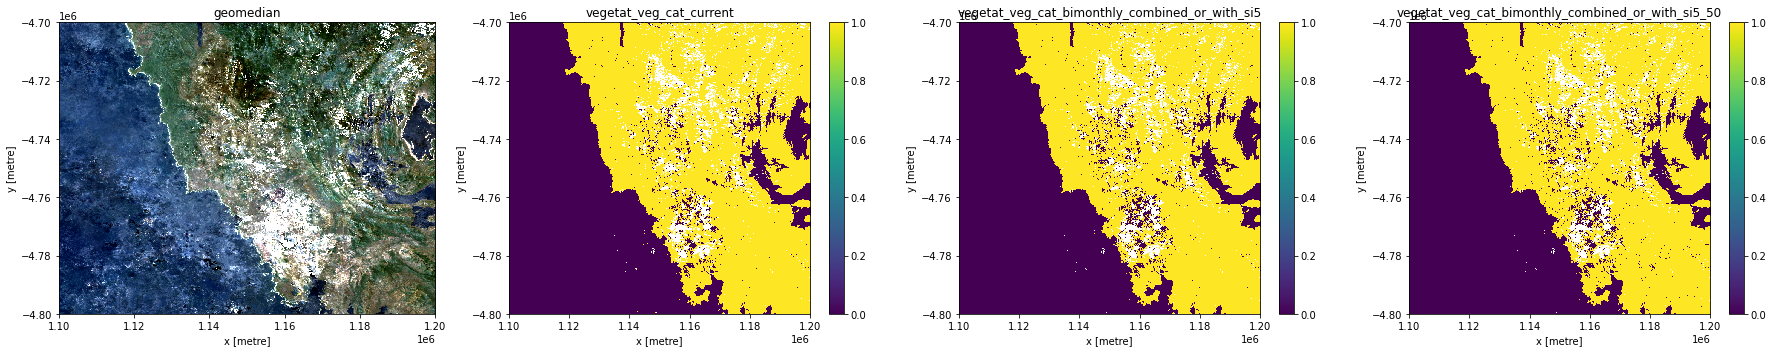

In [26]:
vegetat_veg_cat_bimonthly_combined_or_with_si5_50 = tv_bimonthly_combined_or_50 * wofs_mask * si5

plt.figure(figsize=(25,5))
gs = gridspec.GridSpec(1,4)

ax1=plt.subplot(gs[0,0])
geomedian[['red', 'green', 'blue']].to_array().plot.imshow(robust=True)
ax1.set_title('geomedian')

ax2=plt.subplot(gs[0,1])
vegetat_veg_cat_current.plot.imshow()
ax2.set_title('vegetat_veg_cat_current')

ax3=plt.subplot(gs[0,2])
vegetat_veg_cat_bimonthly_combined_or_with_si5.plot.imshow()
ax3.set_title('vegetat_veg_cat_bimonthly_combined_or_with_si5')

ax4=plt.subplot(gs[0,3])
vegetat_veg_cat_bimonthly_combined_or_with_si5_50.plot.imshow()
ax4.set_title('vegetat_veg_cat_bimonthly_combined_or_with_si5_50')

plt.tight_layout()
plt.show()